This notebook compares the accuracy of multiple data driven ROM methods 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv


import opinf


config = dotenv_values(".env")
from util import *

In [2]:
# Set up hyperparameters for all ROMs
n_ROM = 16 # Dimensionality of state in ROM
n_timesteps = 200 # Number of timesteps to pull from each episode
n_train = 5 # Number of training episodes
n_test = 45 # Number of testing episodes

# Read Data

In [3]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/processedData/"
# Read in a single data file to get dimensions
data = np.load(filepath + "processedData_policySeed_0.npz")
n = data["stateData"].shape[1] # number of states
l = data["inputData"].shape[1] # number of inputs
m = data["centerlineData"].shape[1] # number of centerline points
# initialize 3D matrices to hold data from all episodes
X_fom = np.zeros((n,n_timesteps,n_train+n_test))
U_fom = np.zeros((l,n_timesteps,n_train+n_test))
Y_fom = np.zeros((m,n_timesteps,n_train+n_test))
Xdot_fom = np.zeros((n,n_timesteps,n_train+n_test))


In [4]:
# Read in all data 
for i in range(n_train+n_test):
    data = np.load(filepath+ "processedData_policySeed_"+str(i)+".npz")
    X_fom[:,:,i] = np.transpose(data["stateData"][:n_timesteps,:])
    U_fom[:,:,i] = np.transpose(data["inputData"][:n_timesteps,:]) 
    Y_fom[:,:,i] = np.transpose(data["centerlineData"][:n_timesteps,:])
print("Finished reading in data")
# Collect initial condition offsets for each episode and center each episode
X0 = np.zeros((n,n_train+n_test))
Y0 = np.zeros((m,n_train+n_test))
for i in range(n_train+n_test):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)

Finished reading in data


# Learn System Matrices for Each Method

## OKID + ERA 

### Setup Data matrices  

In [5]:
# Grab input-output data from single episode 
U_era = U_fom[:,:,0]
Y_era = Y_fom[:,:,0]
# # Center output data around initial conditions
# Y_offset_era = Y_era[:,0].reshape(-1,1)
# Y_era = Y_era - Y_offset_era



### OKID Algorithm 

In [6]:
YY = Y_era
UU_size = (U_era.shape[0]*U_era.shape[1],U_era.shape[1])
UU = np.zeros(UU_size)

for i in range(U_era.shape[1]):
    startRow = i*U_era.shape[0]
    endRow = (i+1)*U_era.shape[0]
    UU[startRow:endRow,i:] = U_era[:,0:(U_era.shape[1]-i)]

# compute pseudoinverse of input matrix
UU_pinv = np.linalg.pinv(UU)
# Solve for impulse response  
IR = np.matmul(YY,UU_pinv)


### Eigensystem Realization Algorithm

In [7]:
# Form Hankel matrix for ERA 
N = int(n_timesteps/2-1)
H_size = (m*N,l*N)

H = np.zeros(H_size)
Hprime = np.zeros(H_size)

for i in range(N):
    startRow = m*i 
    endRow = m*(i+1)
    H[startRow:endRow,:]=IR[:,l*(1+i):l*(1+i+N)]
    Hprime[startRow:endRow,:]=IR[:,l*(2+i):l*(2+i+N)]


In [8]:
# Get SVD of Hankel matrix
U, S, Vh = np.linalg.svd(H, full_matrices=False)

Text(0, 0.5, 'Singular Value')

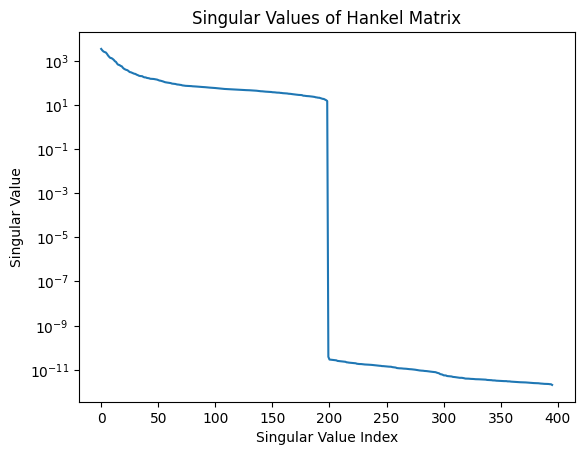

In [9]:
# Plot singular values to determine truncation point
plt.figure()
plt.semilogy(S)
plt.title("Singular Values of Hankel Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")

In [10]:
# Truncate SVD
U = U[:,:n_ROM]
S = np.diag(S[:n_ROM])
Vh = Vh[:n_ROM,:]

In [11]:
# Solve for system matrices
Sigma_tilde_is = np.linalg.inv(np.sqrt(S)) # inverse squareroot of sigma matrix
Sigma_tilde_sqrt = np.sqrt(S) # squareroot of sigma matrix


Em = np.concatenate([np.eye(l),np.zeros((l*(N-1),l))],axis=0)
Ep = np.concatenate([np.eye(m),np.zeros((m*(N-1),m))],axis=0)

A_era = np.matmul(np.matmul(np.matmul(np.matmul(Sigma_tilde_is,np.transpose(U)),Hprime),np.transpose(Vh)),Sigma_tilde_is)
B_era = np.matmul(np.matmul(Sigma_tilde_sqrt,Vh),Em)
C_era = np.matmul(np.transpose(Ep),np.matmul(U,Sigma_tilde_sqrt))
D_era = IR[:,:l]


## DMDc

### Setup Data Matrices

In [12]:
# Initialize data matrices for training and testing
X_train = np.zeros((n,(n_timesteps-1)*n_train))
Xprime_train = np.zeros((n,(n_timesteps-1)*n_train))
Upsilon_train = np.zeros((l,(n_timesteps-1)*n_train))
Y_train = np.zeros((m,(n_timesteps-1)*n_train))
# Load in data from training episodes
for i in range(n_train):
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]


In [13]:
# Form snapshot matrices for DMDc
Omega = np.concatenate([X_train,Upsilon_train],axis=0)


### Solve for Discrete Time System Matrices

In [14]:
# Decompose snapshot matrix using truncated SVD
p_dmd = 1000
r_dmd = n_ROM

U_tilde,Sigma_tilde,Vh_tilde = randomized_svd(Omega, n_components=p_dmd)
Sigma_tilde = np.diag(Sigma_tilde)
U_hat, Sigma_hat, V_hat = randomized_svd(Xprime_train, n_components=r_dmd)
Sigma_hat = np.diag(Sigma_hat)



In [15]:
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

In [16]:
# Solve for system output matrix from full order system
ys = Y_train[:,0:10]
X_PI = np.linalg.pinv(X_train[:,0:10])
C_dmdc = ys@X_PI

## OpInf

### Setup Data Matrices

In [17]:
# Simulation Parameters
dt = 0.0005


In [18]:
# Initialize data matrices for training and testing
Q_train = np.zeros((n,(n_timesteps)*n_train))
Qdot_train = np.zeros((n,(n_timesteps)*n_train))
Upsilon_train = np.zeros((l,(n_timesteps)*n_train))
Y_train = np.zeros((m,(n_timesteps)*n_train))
# Load in data from training episodes
for i in range(n_train):
    Q_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = X_fom[:,:,i]
    Qdot_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = opinf.pre.ddt(X_fom[:,:,i], dt, order=6) 
    Upsilon_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = U_fom[:,:,i]
    Y_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = Y_fom[:,:,i]


In [19]:
# Setup OpInf Solver
t = np.arange(0,dt*n_timesteps,dt)
basis = opinf.pre.PODBasis().fit(Q_train,r=n_ROM) # fit basis to training data
rom_opInf = opinf.DiscreteOpInfROM(modelform="AB") 
solver = opinf.lstsq.L2Solver(regularizer=1e-2)         # Select a least-squares solver with regularization.
rom_opInf.fit(basis, Q_train, Qdot_train, Upsilon_train,solver=solver)                  # Construct the ROM by solving the operator inference.


Reduced-order model structure: q_{j+1} = Aq_{j} + Bu_{j}
Full-order dimension    n = 23205
Input/control dimension m = 4
Reduced-order dimension r = 16

In [20]:
# Extract system matrices from OpInf ROM
A_opInf = np.array(rom_opInf.A_.entries)
B_opInf = np.array(rom_opInf.B_.entries)
basis_opInf = np.array(basis.entries)


In [21]:
# Solve for system output matrix from full order system
ys = Y_train[:,0:10]
X_PI = np.linalg.pinv(X_train[:,0:10])
C_opInf = ys@X_PI

## LOpInf

These results are currently read in from a data file

# Verification Experiments

## Simulate System Responses from Training and Test Episodes

### OKID/ERA

In [22]:
# Initialize data matrices for training and testing responses
X_hat_rom_era = np.zeros((n_ROM,n_timesteps,n_train+n_test))
Y_hat_rom_era = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_era[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_era[:,[0],i] = C_era@X_hat_rom_era[:,[0],i] + D_era@U_fom[:,[0],i]


In [23]:
# Simulate ERA ROM for all episodes
for i in range(n_train+n_test):
    # Simulate ERA ROM
    for j in range(n_timesteps-1):
        X_hat_rom_era[:,[j+1],i] = A_era@X_hat_rom_era[:,[j],i] + B_era@U_fom[:,[j],i]
        Y_hat_rom_era[:,[j+1],i] = C_era@X_hat_rom_era[:,[j+1],i] + D_era@U_fom[:,[j+1],i]


In [24]:
# Uncenter output data with initial conditions for each episode
for i in range(n_train+n_test):
    Y_hat_rom_era[:,:,i] = Y_hat_rom_era[:,:,i] + Y0[:,i].reshape(m,1)


### DMDc

In [25]:
# Initialize data matrices for training and testing responses
X_hat_rom_dmdc = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_dmdc = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_dmdc = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_dmdc[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    X_hat_fom_dmdc[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_dmdc[:,[0],i] = C_dmdc@U_hat@X_hat_rom_dmdc[:,[0],i]

In [26]:
# Simulate DMDc ROM for all episodes
for i in range(n_train+n_test):
    # Simulate DMDc ROM
    for j in range(n_timesteps-1):
        X_hat_rom_dmdc[:,[j+1],i] = A_dmdc@X_hat_rom_dmdc[:,[j],i] + B_dmdc@U_fom[:,[j],i]
        X_hat_fom_dmdc[:,[j+1],i] = U_hat@X_hat_rom_dmdc[:,[j+1],i] # Compute full order state from reduced order state
        Y_hat_rom_dmdc[:,[j+1],i] = C_dmdc@U_hat@X_hat_rom_dmdc[:,[j+1],i]

In [27]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    X_hat_fom_dmdc[:,:,i] = X_hat_fom_dmdc[:,:,i] + X0[:,i].reshape(n,1)
    Y_hat_rom_dmdc[:,:,i] = Y_hat_rom_dmdc[:,:,i] + Y0[:,i].reshape(m,1)

### OpInf

In [28]:
# Initialize data matrices for training and testing responses
X_hat_rom_opInf = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_opInf = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_opInf = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_opInf[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    X_hat_fom_opInf[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_opInf[:,[0],i] = C_opInf@X_hat_fom_opInf[:,[0],i]
    

In [29]:
# Simulate OpInf ROM for all episodes
for i in range(n_train+n_test):
    # Simulate OpInf ROM
    for j in range(n_timesteps-1):
        X_hat_rom_opInf[:,[j+1],i] = A_opInf@X_hat_rom_opInf[:,[j],i] + B_opInf@U_fom[:,[j],i]
        X_hat_fom_opInf[:,[j+1],i] = basis_opInf@X_hat_rom_opInf[:,[j+1],i] # Compute full order state from reduced order state
        Y_hat_rom_opInf[:,[j+1],i] = C_opInf@X_hat_fom_opInf[:,[j+1],i]

In [30]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    X_hat_fom_opInf[:,:,i] = X_hat_fom_opInf[:,:,i] + X0[:,i].reshape(n,1)
    Y_hat_rom_opInf[:,:,i] = Y_hat_rom_opInf[:,:,i] + Y0[:,i].reshape(m,1)

### LOpInf

In [31]:
# Read in data from LOpInf Trials
mat = scipy.io.loadmat(filepath+'lopinf_rom_r_16.mat')
# Extract data from LOpInf Trials
X_hat_rom_lopinf = mat['stateData_approx']
Y_hat_rom_lopinf = mat['outputData_approx']

### Uncenter Full Order Model

# Uncenter FOM


In [32]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    X_fom[:,:,i] = X_fom[:,:,i] + X0[:,i].reshape(n,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] + Y0[:,i].reshape(m,1)
    

## Response Visualizations

### First Output Response

#### Training Set 1

Text(0.5, 1.0, 'First Output from First Training Episode')

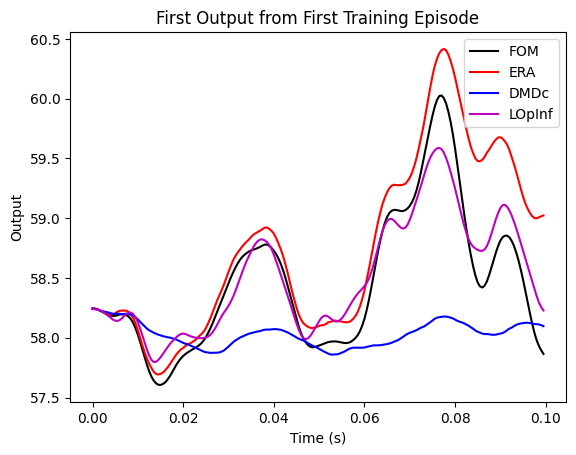

In [33]:
# Plot first output from first training episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,0],'k',label='FOM')
plt.plot(t,Y_hat_rom_era[0,:,0],'r',label='ERA')
plt.plot(t,Y_hat_rom_dmdc[0,:,0],'b',label='DMDc')
#plt.plot(t,Y_hat_rom_opInf[0,:,0],'g',label='OpInf')
plt.plot(t,Y_hat_rom_lopinf[0,:,0],'m',label='LOpInf')
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Training Episode'
plt.title(title)

#### Test Set 1

Text(0.5, 1.0, 'First Output from First Testing Episode')

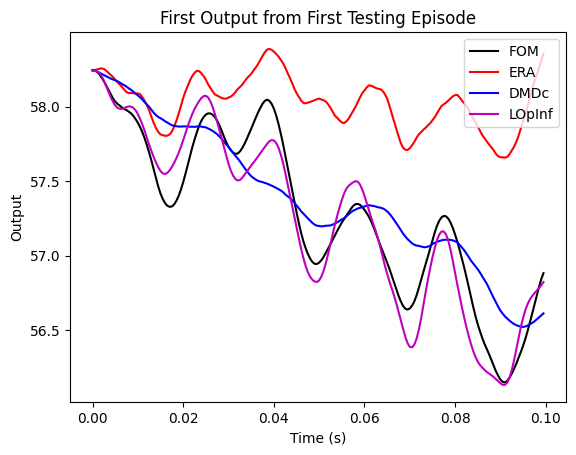

In [34]:
# Plot first output from first testing episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,n_train],'k',label='FOM')
plt.plot(t,Y_hat_rom_era[0,:,n_train],'r',label='ERA')
plt.plot(t,Y_hat_rom_dmdc[0,:,n_train],'b',label='DMDc')
# plt.plot(t,Y_hat_rom_opInf[0,:,n_train],'g',label='OpInf')
plt.plot(t,Y_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf')
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Testing Episode'
plt.title(title)


### First state Response

#### First Training Episode

Text(0.5, 1.0, 'First State from First Training Episode')

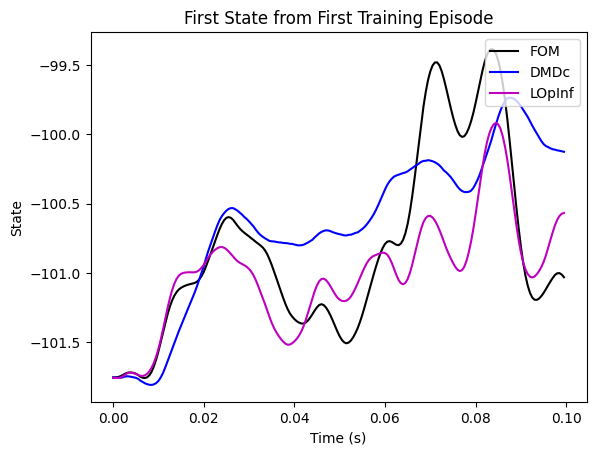

In [35]:
# Plot first state from first training episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,0],'k',label='FOM')
plt.plot(t,X_hat_fom_dmdc[0,:,0],'b',label='DMDc')
# plt.plot(t,X_hat_fom_opInf[0,:,0],'g',label='OpInf')
plt.plot(t,X_hat_rom_lopinf[0,:,0],'m',label='LOpInf')
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Training Episode'
plt.title(title)

#### First Test Episode

Text(0.5, 1.0, 'First State from First Testing Episode')

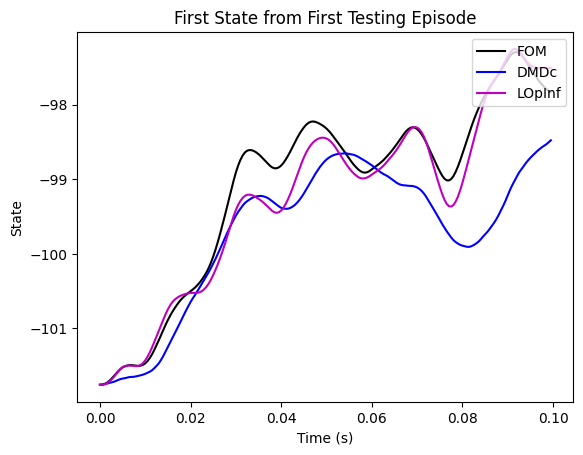

In [36]:
# Plot first state from first testing episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,n_train],'k',label='FOM')
plt.plot(t,X_hat_fom_dmdc[0,:,n_train],'b',label='DMDc')
#plt.plot(t,X_hat_fom_opInf[0,:,n_train],'g',label='OpInf')
plt.plot(t,X_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf')
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Testing Episode'
plt.title(title)

### Centerline Videos

In [37]:
# Setup save path for videos
video_path = config["currentDirectory"] +"data/videos/"
videoName_test = 'test_episode.mp4'
videoName_train = 'train_episode.mp4'
# Number of frames and playspeed for video
numFrames = n_timesteps
fps = 30
duration = numFrames/fps
# Axis limits for video
xlim_max = 300
xlim_min = -250 
zlim_max = 25
zlim_min = 10
ulim_max = 0.2
ulim_min = -0.2
# Parameters for centerline reduction 
n_seg = 10 # number of discrete points to use for centerline
N_local = 20 # number of local points to use when averaging around each discrete point



#### Training Set 1

Generate animation of centerline motion using output data from all modelling methods for the first training set


Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/train_episode.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/train_episode.mp4



Moviepy - Done !
Moviepy - video ready /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/train_episode.mp4


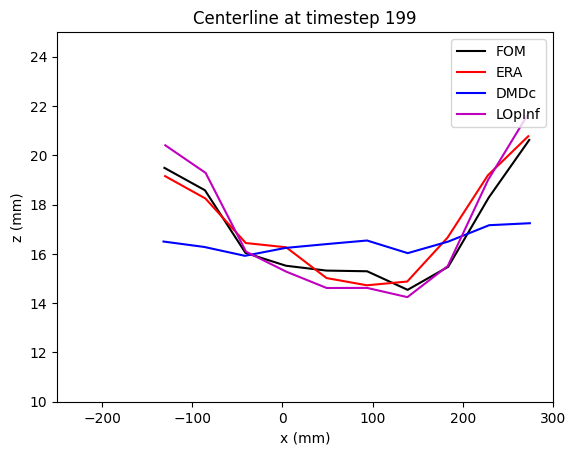

In [38]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first training episode
    centerline_fom = Y_fom[:,i,0].reshape(int(m/3),3)
    centerline_era = Y_hat_rom_era[:,i,0].reshape(int(m/3),3)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,0].reshape(int(m/3),3)
    #centerline_opInf = Y_hat_rom_opInf[:,i,0].reshape(int(m/3),3)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,0].reshape(int(m/3),3)
    # Compute reduced centerlines for each method
    centerline_fom_red = reduceCenterline(n_seg,centerline_fom,N_local)
    centerline_era_red = reduceCenterline(n_seg,centerline_era,N_local)
    centerline_dmdc_red = reduceCenterline(n_seg,centerline_dmdc,N_local)
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,0],centerline_fom_red[:,1],'k',label='FOM')
    ax.plot(centerline_era_red[:,0],centerline_era_red[:,1],'r',label='ERA')
    ax.plot(centerline_dmdc_red[:,0],centerline_dmdc_red[:,1],'b',label='DMDc')
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf')
    ax.plot(centerline_lopinf_red[:,0],centerline_lopinf_red[:,1],'m',label='LOpInf')
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_train, fps=fps)



#### Test Set 1

Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/test_episode.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/test_episode.mp4



Moviepy - Done !
Moviepy - video ready /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/test_episode.mp4


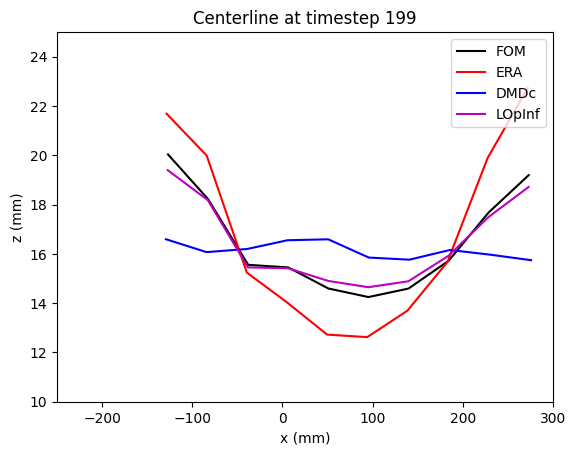

In [39]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback 
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first testing episode
    centerline_fom = Y_fom[:,i,n_train].reshape(int(m/3),3)
    centerline_era = Y_hat_rom_era[:,i,n_train].reshape(int(m/3),3)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,n_train].reshape(int(m/3),3)
    #centerline_opInf = Y_hat_rom_opInf[:,i,n_train].reshape(int(m/3),3)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,n_train].reshape(int(m/3),3)
    # Compute reduced centerlines for each method
    centerline_fom_red = reduceCenterline(n_seg,centerline_fom,N_local)
    centerline_era_red = reduceCenterline(n_seg,centerline_era,N_local)
    centerline_dmdc_red = reduceCenterline(n_seg,centerline_dmdc,N_local)
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,0],centerline_fom_red[:,1],'k',label='FOM')
    ax.plot(centerline_era_red[:,0],centerline_era_red[:,1],'r',label='ERA')
    ax.plot(centerline_dmdc_red[:,0],centerline_dmdc_red[:,1],'b',label='DMDc')
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf')
    ax.plot(centerline_lopinf_red[:,0],centerline_lopinf_red[:,1],'m',label='LOpInf')
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_test, fps=fps)


## Relative Error Computations

### Relative Output Errors

#### Training Episodes

In [40]:
# Compute relative error in frobenius norm for all training episodes
rel_err_era_train = np.zeros((n_train,1))
rel_err_dmdc_train = np.zeros((n_train,1))
rel_err_opInf_train = np.zeros((n_train,1))
rel_err_lopinf_train = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_era_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_era[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_dmdc_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_dmdc[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_opInf_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_opInf[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_lopinf_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_lopinf[:,:,i])/np.linalg.norm(Y_fom[:,:,i])

#### Test Episodes


In [41]:
# Compute relative error in frobenius norm for all testing episodes
rel_err_era_test = np.zeros((n_test,1))
rel_err_dmdc_test = np.zeros((n_test,1))
rel_err_opInf_test = np.zeros((n_test,1))
rel_err_lopinf_test = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_era_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_era[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_dmdc_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_dmdc[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_opInf_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_opInf[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_lopinf_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])

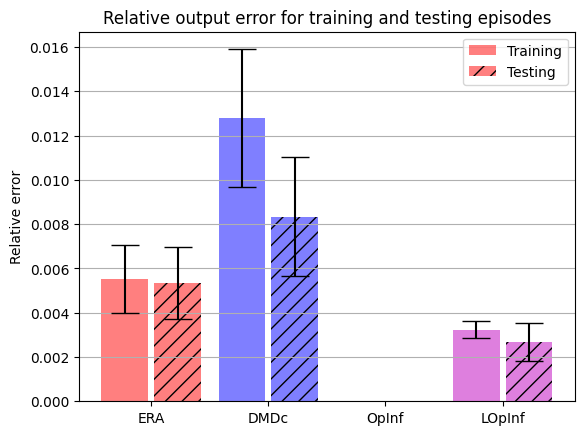

In [42]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,8,2)-0.45,[np.mean(rel_err_era_train),np.mean(rel_err_dmdc_train),np.mean(rel_err_opInf_train),np.mean(rel_err_lopinf_train)],yerr=[np.std(rel_err_era_train),np.std(rel_err_dmdc_train),np.std(rel_err_opInf_train),np.std(rel_err_lopinf_train)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,8,2)+0.45,[np.mean(rel_err_era_test),np.mean(rel_err_dmdc_test),np.mean(rel_err_opInf_test),np.mean(rel_err_lopinf_test)],yerr=[np.std(rel_err_era_test),np.std(rel_err_dmdc_test),np.std(rel_err_opInf_test),np.std(rel_err_lopinf_test)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,8,2))
ax.set_xticklabels(['ERA','DMDc','OpInf','LOpInf'])
ax.set_title('Relative output error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()


### Relative State Errors

In [43]:
# Compute relative error in frobenius norm for all training episodes of full order states for each method except ERA
rel_err_dmdc_train_full = np.zeros((n_train,1))
rel_err_opInf_train_full = np.zeros((n_train,1))
rel_err_lopinf_train_full = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_dmdc_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_dmdc[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    rel_err_opInf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_opInf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    rel_err_lopinf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_rom_lopinf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    


In [44]:
# Compute relative error in frobenius norm for all testing episodes of full order states for each method except ERA
rel_err_dmdc_test_full = np.zeros((n_test,1))
rel_err_opInf_test_full = np.zeros((n_test,1))
rel_err_lopinf_test_full = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_dmdc_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_dmdc[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    rel_err_opInf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_opInf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    rel_err_lopinf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])



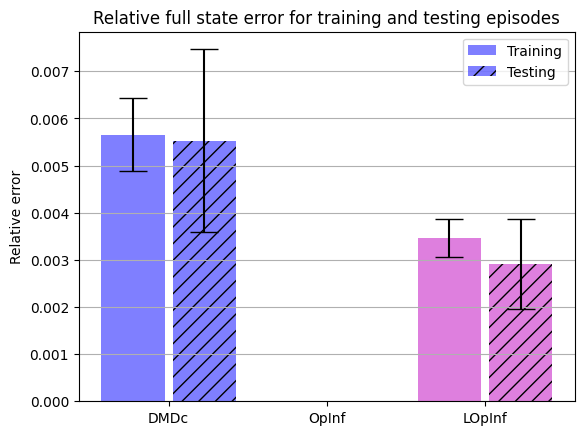

In [45]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,6,2)-0.45,[np.mean(rel_err_dmdc_train_full),np.mean(rel_err_opInf_train_full),np.mean(rel_err_lopinf_train_full)],yerr=[np.std(rel_err_dmdc_train_full),np.std(rel_err_opInf_train_full),np.std(rel_err_lopinf_train_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45,[np.mean(rel_err_dmdc_test_full),np.mean(rel_err_opInf_test_full),np.mean(rel_err_lopinf_test_full)],yerr=[np.std(rel_err_dmdc_test_full),np.std(rel_err_opInf_test_full),np.std(rel_err_lopinf_test_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['DMDc','OpInf','LOpInf'])
ax.set_title('Relative full state error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()



# 3D Visualizations

In [46]:
episode = 0
plotter = pv.Plotter(notebook=False, off_screen=True)
# Open a gif
plotter.open_gif(video_path+'MeshTraining0.gif')
for i in range(75):
    # Clear plotting window
    plotter.clear()
    # Generate volumes for a ith timestep and reshape into n/3 x 3 array for each method except ERA
    volume_fom = pv.PolyData(X_fom[:,i,episode].reshape(int(n/3),3)).delaunay_3d().rotate_x(90)
    volume_dmdc = pv.PolyData(X_hat_fom_dmdc[:,i,episode].reshape(int(n/3),3)).delaunay_3d().rotate_x(90)
    volume_opInf = pv.PolyData(X_hat_fom_opInf[:,i,episode].reshape(int(n/3),3)).delaunay_3d().rotate_x(90)
    volume_lopinf = pv.PolyData(X_hat_rom_lopinf[:,i,episode].reshape(int(n/3),3)).delaunay_3d().rotate_x(90)
    # Plot volumes
    plotter.add_mesh(volume_dmdc.extract_geometry(), color='blue', show_edges=False, opacity = 0.5)
    # plotter.add_mesh(volume_opInf.extract_geometry(), color='green', show_edges=False, opacity = 0.2)
    plotter.add_mesh(volume_lopinf.extract_geometry(), color='magenta', show_edges=False, opacity = 0.5)
    plotter.add_mesh(volume_fom.extract_geometry(), color='black', show_edges=False, opacity = 0.5)

    # Write frame
    plotter.write_frame()
# Close movie and delete object
plotter.close()



2023-06-09 13:38:30.726 ( 259.296s) [        E121B740]      vtkDelaunay3D.cxx:518   WARN| vtkDelaunay3D (0x8a4b610): 41 degenerate triangles encountered, mesh quality suspect
2023-06-09 13:38:31.131 ( 259.700s) [        E121B740]      vtkDelaunay3D.cxx:518   WARN| vtkDelaunay3D (0x5a35de0): 41 degenerate triangles encountered, mesh quality suspect
2023-06-09 13:38:31.524 ( 260.093s) [        E121B740]      vtkDelaunay3D.cxx:518   WARN| vtkDelaunay3D (0x5257f50): 41 degenerate triangles encountered, mesh quality suspect


: 

: 